# Telecom Churn dataset classification using tensorflow and keras

<img src="https://digital.report/wp-content/uploads/2017/04/558519547-1078x516.jpg">

In [1]:
print()
print(format('Recipe for Data Science Competition - DSC_Recipe_14','*^65'))
print(format('Classification with OpenML telco Churn dataset using tensorflow and keras', '*^95'))    
print(format('Package: scikit-learn, Keras and TensorFlow ','*^65'))            
print(format('Model: Keras Model','*^65'))            
print(format('DataSet: OpenML telco Churn Dataset', '*^65'))    
print(format('Model selection: using Grid Search Cross Validation (GSCV)', '*^65'))  


*******Recipe for Data Science Competition - DSC_Recipe_14*******
***********Classification with OpenML telco Churn dataset using tensorflow and keras***********
**********Package: scikit-learn, Keras and TensorFlow ***********
***********************Model: Keras Model************************
***************DataSet: OpenML telco Churn Dataset***************
***Model selection: using Grid Search Cross Validation (GSCV)****


## 0. Loading required libraries

In [2]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import pickle as pk    
from sklearn.model_selection import train_test_split, cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical        
from sklearn.preprocessing import MinMaxScaler        
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
    
start_time = time.time()

## 1. Helper modules for Descriptive Statistics

In [3]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [5]:
def get_top_abs_correlations(df, n=5): 
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [6]:
def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j), 
                X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],
                columns=['pairs','corr'])
    print(df.sort_values(by='corr',ascending=False))
    print()

In [7]:
# Helper module for Label Encoding for Categorical Features
def dummyEncode(df):
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

## 2. Loading dataset

In [8]:
def load_dataset(filename):
        
    dataset = pd.read_csv(filename, sep = ',')
        
    print(dataset.shape);    print(dataset.head(5));    print(dataset.columns);
    print(dataset.dtypes)
        
    feature_names = ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 
    'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
    'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
    'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code']
        
    target = 'Churn'
        
    dataset = dummyEncode(dataset[['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 
    'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
    'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
    'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code', 'Churn']])
        
    return feature_names, target, dataset

## 3. Find missing values in dataset if exists

In [9]:
    def find_miising_value(feature_names, target, dataset):
        
        print()
        print('#---------------------------------------------------------------')
        print('Check for Mising Value or NaN Value in the Dataset')
        print('#---------------------------------------------------------------')
        # Method - 1
        # Count Number of Missing Value on Each Column    
        print('\nCount Number of Missing Value on Each Column: ')        
        print(dataset.isnull().sum(axis=0))

        # Method - 2
        # Check if there are any missing values in Dataset
        feature_count = dataset.columns[dataset.isnull().sum() != 0].size
        print()
        print("Total Features with missing Values = " + str(feature_count))

        if (feature_count):
            print()
            print("Features with NaN => {}".format(list(dataset.columns[dataset.isnull().sum() != 0])))
            print('Count Number of Missing Value on Each Column: ')        
            print(dataset[dataset.columns[dataset.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False))

        print()
        print('#---------------------------------------------------------------')
        print('Check and Remove constant columns in the Dataset')
        print('#---------------------------------------------------------------')
        colsToRemove = []
        for col in dataset.columns:
            if col not in ['Churn']:
                if dataset[col].std() == 0: 
                    colsToRemove.append(col)
        print()
        print("Removed `{}` Constant Columns: ".format(len(colsToRemove)))
        print(colsToRemove)
        # remove constant columns in the Dataset
        dataset.drop(colsToRemove, axis=1, inplace=True)

        print()
        print('#---------------------------------------------------------------')
        print('Check and Remove Duplicate Columns in the Dataset')
        print('#---------------------------------------------------------------')
        print()
        print(dataset.columns); print(dataset.head(5))
        print('\nDuplicate Columns in the Dataset: \n', dataset.columns.duplicated())        
        dataset = dataset.loc[:, ~dataset.columns.duplicated()]
        print()
        print(dataset.columns); print(dataset.head(5))
        
        print()
        print('#---------------------------------------------------------------')
        print('Check and Drop Sparse Data/Columns in the Dataset')
        print('#---------------------------------------------------------------')
        flist = [x for x in dataset.columns if not x in ['Churn']]
        print(); print(flist)
        for f in flist:
            if len(np.unique(dataset[f])) < 2:
                print('Feature contains Sparse Data: ', f)
                dataset.drop(f, axis=1, inplace=True)
        print()
        print(dataset.columns); print(dataset.head(5))
        
        # --------------------------------------------------
        # Missing Values treatment in the DataSet (if any)
        # --------------------------------------------------    

        # Filling NULL values according to their dataTypes
        # Group Dataset according to different dataTypes
        gd = dataset.columns.to_series().groupby(dataset.dtypes).groups
        print('\nGroup Columns according to their dataTypes: \n', gd)  
        colNames = dataset.columns.values.tolist()
        for colName in colNames:
            if dataset[colName].dtypes == 'int64':
                dataset[colName] = dataset[colName].fillna(0)
            if dataset[colName].dtypes == 'float64':
                dataset[colName] = dataset[colName].fillna(0.0) 
            if dataset[colName].dtypes == 'object':
                dataset[colName] = dataset[colName].fillna('Unknown')    

        ## Count Number of Missing Value on Each Column    
        print('\nCount Number of Missing Value on Each Column: ')        
        print(dataset.isnull().sum(axis=0))

        # Check if there are any missing values in Dataset
        feature_count = dataset.columns[dataset.isnull().sum() != 0].size
        print()
        print("Total Features with missing Values = " + str(feature_count))
        
        return(dataset)

## 4. Descriptive statistics and correlation matrix

In [10]:
def data_descriptiveStats(feature_names, target, dataset):
    # Count Number of Missing Value on Each Column    
    print(); print('Count Number of Missing Value on Each Column: ')        
    print(); print(dataset[feature_names].isnull().sum(axis=0))
    print(); print(dataset[target].isnull().sum(axis=0))    
    
    # Get Information on the feature variables
    print(); print('Get Information on the feature variables: ')            
    print(); print(dataset[feature_names].info())
    print(); print(dataset[feature_names].describe())
    
    # correlation
    pd.set_option('precision', 2)
    print(); print(dataset[feature_names].corr())    
    
    # Ranking of Correlation Coefficients among Variable Pairs
    print(); print("Ranking of Correlation Coefficients:")    
    corrank(dataset[feature_names])

    # Print Highly Correlated Variables
    print(); print("Highly correlated variables (Absolute Correlations):")
    print(); print(get_top_abs_correlations(dataset[feature_names], 8))
    
    # Get Information on the target    
    print(); print(dataset[target].describe())    
    print(); print(dataset.groupby(target).size())    

## 5. Data visualisation and correlation graph

In [11]:
    def data_visualization(feature_names, target, dataset):
        # BOX plots USING box and whisker plots
        i = 1
        print(); print('BOX plot of each numerical features')
        plt.figure(figsize=(11,9))     
        for col in feature_names:
            plt.subplot(5,4,i)
            plt.axis('on')
            plt.tick_params(axis='both', left=True, top=False, right=False, bottom=True, 
                            labelleft=False, labeltop=False, labelright=False, labelbottom=False)
            dataset[col].plot(kind='box', subplots=True, sharex=False, sharey=False)
            i += 1
        plt.show()    
    
        # USING histograms
        j = 1
        print(); print('Histogram of each Numerical Feature')
        plt.figure(figsize=(11,9))     
        for col in feature_names:
            plt.subplot(5,4,j)
            plt.axis('on')
            plt.tick_params(axis='both', left=True, top=False, right=False, bottom=False, 
                            labelleft=False, labeltop=False, labelright=False, labelbottom=False)
            dataset[col].hist()
            j += 1
        plt.show()

        # correlation matrix
        print(); print('Correlation Matrix of All Numerical Features')   
        fig = plt.figure(figsize=(11,9))
        ax = fig.add_subplot(111)
        cax = ax.matshow(dataset[feature_names].corr(), vmin=-1, vmax=1, interpolation='none')
        fig.colorbar(cax)
        ticks = np.arange(0,19,1)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        plt.show()

        # Correlation Plot using seaborn
        print(); print("Correlation plot of Numerical features")
        # Compute the correlation matrix
        corr = dataset[feature_names].corr()
        print(corr)
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin= -1.0, center=0, square=True, 
                    linewidths=.5, cbar_kws={"shrink": .5})
        plt.show()    
    
        # Pie chart for Categorical Variables
        print(); print('PIE Chart of for Target: ')
        plt.figure(figsize=(11,9)) 
        i = 1
        for colName in [target]:
            labels = []; sizes = [];
            df = dataset.groupby(colName).size()
            for key in df.keys():
                labels.append(key)
                sizes.append(df[key])
            # Plot PIE Chart with %
            plt.subplot(2,2,i)
            plt.axis('on')
            plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                            labelleft=True, labeltop=True, labelright=False, labelbottom=False)        
            plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
            plt.axis('equal')
            i += 1; plt.savefig('Piefig.pdf', format='pdf')
        plt.show()    

## 6. Data split to train and test datasets

In [12]:
    def data_split(feature_names, target, dataset):
        
        # Data Transform - Split train : test datasets
        X_train, X_test, y_train, y_test = train_test_split(dataset.loc[:, feature_names], 
                                dataset.loc[:, 'Churn'], test_size=0.20)
        
        # normalize the dataset i.e. X_train and X_test
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_train = scaler.fit_transform(X_train)    
        X_test = scaler.fit_transform(X_test)    
    
        # One-hot encode target vector to create a target matrix
        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)
        
        return X_train, X_test, y_train, y_test

In [12]:
    def training_model(X_train, y_train):
        
        model = Sequential()
        model.add(Dense(units = 256, input_dim=19, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(units = 128, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(units = 56, activation='relu'))
        model.add(Dropout(0.15))  
        model.add(Dense(units = 28, activation='relu'))
        model.add(Dropout(0.15))        
        model.add(Dense(units = 2,  activation='softmax'))
        
        # Model Summary
        print(model.summary())                
        
        # Compile the Model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        
        # Train the Model
        history = model.fit(X_train, y_train, epochs=500, batch_size=64, verbose = 1,
                            validation_split=0.20)        
        
        return(model, history)

In [13]:
    def create_model():
            # create model
            model = Sequential()
            model.add(Dense(units = 500, input_dim=19, activation='relu'))
            model.add(Dense(units = 250, activation='relu'))
            model.add(Dense(units = 150, activation='relu'))            
            model.add(Dense(units = 2,  activation='softmax'))
        
            # Compile the Model
            model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['acc'])

            return model

In [14]:
    def training_model(X_train, y_train):
        
        # create classifier for use in scikit-learn
        model = KerasClassifier(build_fn=create_model, epochs=500, batch_size=64, verbose=1)
        
        # evaluate model using 10-fold cross validation in scikit-learn
        results = cross_val_score(model, X_train, y_train, cv = 2)
        print(); print("Kfold CV results: ", results)
        print("Kfold CV results (mean): ", results.mean())
        print("Kfold CV results (std): ", results.std()) 

        # Train the Model
        history = model.fit(X_train, y_train, epochs=500, batch_size=64, verbose = 1,
                            validation_split=0.20)        
        
        return(model, history)

In [15]:
    def evaluate_model(model, history, X_test, y_test):    
        
        # list all data in history
        print(history.history.keys()); #print(history.history)
        # summarize history for accuracy
        plt.plot(history.history['acc']); plt.plot(history.history['val_acc']);
        plt.title('model accuracy'); plt.ylabel('accuracy'); plt.xlabel('epoch'); 
        plt.legend(['train', 'test'], loc='upper left'); plt.show()
        # summarize history for loss
        plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
        plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch');
        plt.legend(['train', 'test'], loc='upper left'); plt.show()        
        
        y_test = np.argmax(y_test, axis = 1)

        # Evaluate the skill of the Trained model
        pred_Class          = model.predict(X_test)
        pred_proba          = model.predict_proba(X_test)
        acc                 = accuracy_score(y_test, pred_Class)
        classReport         = classification_report(y_test, pred_Class)
        confMatrix          = confusion_matrix(y_test, pred_Class) 
        kappa_score         = cohen_kappa_score(y_test, pred_Class)         
        
        print(); print('Evaluation of the trained model: ')
        print(); print('Accuracy : ', acc)
        print(); print('Kappa Score : ', kappa_score)
        print(); print('Confusion Matrix :\n', confMatrix)
        print(); print('Classification Report :\n',classReport)

        pred_proba = model.predict_proba(X_test)
        
        # Add more plots here using scikit-plot
        # ROC curves
        skplt.metrics.plot_roc(y_test,pred_proba,figsize=(9,9)); plt.show()

        # Confusion matrix
        skplt.metrics.plot_confusion_matrix(y_test,pred_Class,figsize=(9,9)); plt.show()        
        
        # precision recall curve
        skplt.metrics.plot_precision_recall(y_test, pred_proba, 
                title='Precision-Recall Curve', plot_micro=True, 
                classes_to_plot=None, ax=None, figsize=(9,9), 
                cmap='nipy_spectral', title_fontsize='large', 
                text_fontsize='medium'); plt.show()
        
        return model

## 7. Make Prediction

In [16]:
    def save_model(model):
        model.model.save('DSC_Recipe_14_model.h5')

In [18]:
    def final_prediction(feature_names, filename):
        # load model
        from keras.models import load_model
        # create classifier for use in scikit-learn
        model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=64, verbose=1)
        model.model = load_model('DSC_Recipe_14_model.h5')
        
        # load dataset
        dataset = pd.read_csv(filename, sep = ',')

        print(dataset.shape);    print(dataset.head(5));    print(dataset.columns);
        print(dataset.dtypes)

        dataset = dummyEncode(dataset)

        # normalize the dataset 
        scaler = MinMaxScaler(feature_range=(0, 1))
        # final prediction and results
        predicted_class     = model.model.predict_classes(scaler.fit_transform(dataset[feature_names]))
        pred_proba          = model.model.predict(scaler.fit_transform(dataset[feature_names]))
        
        dataset['predicted_class'] = predicted_class

        # Evaluate the skill of the Trained model
        acc                 = accuracy_score(dataset['Churn'], predicted_class)
        classReport         = classification_report(dataset['Churn'], predicted_class)
        confMatrix          = confusion_matrix(dataset['Churn'], predicted_class) 
        kappa_score         = cohen_kappa_score(dataset['Churn'], predicted_class)         
        
        print(); print('Testing Results of the trained model: ')
        print(); print('Accuracy : ', acc)
        print(); print('Kappa Score : ', kappa_score)
        print(); print('Confusion Matrix :\n', confMatrix)
        print(); print('Classification Report :\n',classReport)
        
        # ROC curves
        skplt.metrics.plot_roc(dataset['Churn'],pred_proba,figsize=(7,7)); plt.show()

        # Confusion matrix
        skplt.metrics.plot_confusion_matrix(dataset['Churn'],
                                            predicted_class,figsize=(7,7)); plt.show()        

        # precision recall curve
        skplt.metrics.plot_precision_recall(dataset['Churn'], pred_proba, 
                title='Precision-Recall Curve', plot_micro=True, 
                classes_to_plot=None, ax=None, figsize=(7,7), 
                cmap='nipy_spectral', title_fontsize='large', 
                text_fontsize='medium'); plt.show()               

        dataset.to_csv('FinalResult.csv', index = False, 
                       columns = ['Churn', 'predicted_class'])

## 8. Execute algorithm using functions above


Execution Time 1599327804.3200982 seconds: 
(3333, 21)
   Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  Intl_Mins  \
0             128             25     265.1     197.4       244.7       10.0   
1             107             26     161.6     195.5       254.4       13.7   
2             137              0     243.4     121.2       162.6       12.2   
3              84              0     299.4      61.9       196.9        6.6   
4              75              0     166.7     148.3       186.9       10.1   

   CustServ_Calls Churn Intl_Plan Vmail_Plan  ...  Day_Charge  Eve_Calls  \
0               1    no        no        yes  ...       45.07         99   
1               1    no        no        yes  ...       27.47        103   
2               0    no        no         no  ...       41.38        110   
3               2    no       yes         no  ...       50.90         88   
4               3    no       yes         no  ...       28.34        122   

   Eve_Charg

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


                           pairs  corr
42        (Day_Mins, Day_Charge)  1.00
59        (Eve_Mins, Eve_Charge)  1.00
75    (Night_Mins, Night_Charge)  1.00
90      (Intl_Mins, Intl_Charge)  1.00
24   (Vmail_Message, Vmail_Plan)  0.96
..                           ...   ...
103      (CustServ_Calls, State) -0.03
33        (Vmail_Message, State) -0.03
68       (Night_Mins, Intl_Plan) -0.03
111    (Intl_Plan, Night_Charge) -0.03
124          (Vmail_Plan, State) -0.03

[171 rows x 2 columns]


Highly correlated variables (Absolute Correlations):

Day_Mins       Day_Charge      1.00
Eve_Mins       Eve_Charge      1.00
Night_Mins     Night_Charge    1.00
Intl_Mins      Intl_Charge     1.00
Vmail_Message  Vmail_Plan      0.96
Intl_Plan      Day_Charge      0.05
Day_Mins       Intl_Plan       0.05
Intl_Plan      Area_Code       0.05
dtype: float64

count    3333.00
mean        0.14
std         0.35
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Churn,

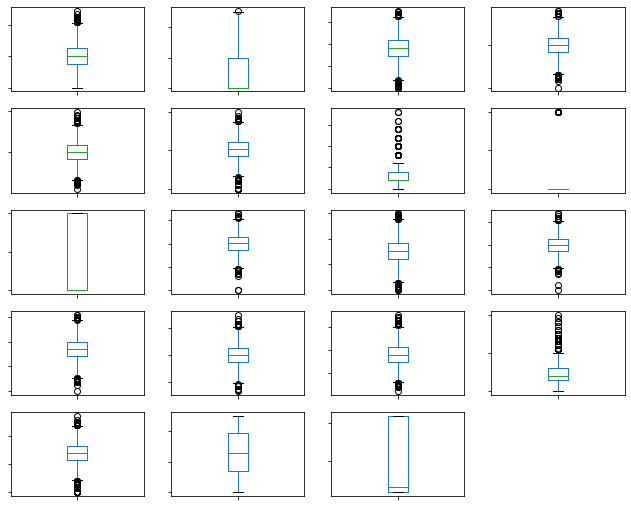


Histogram of each Numerical Feature


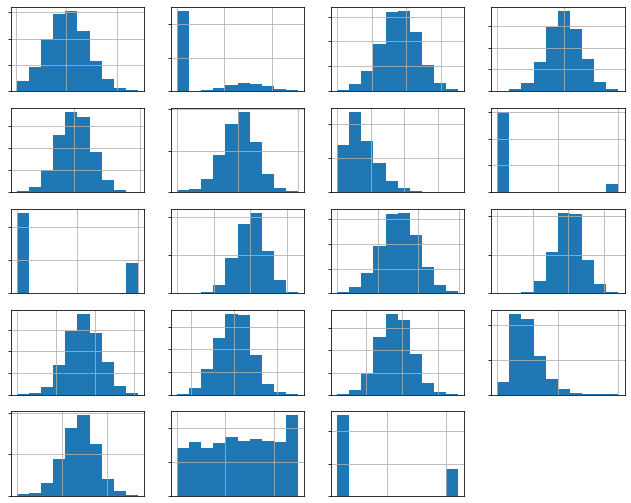


Correlation Matrix of All Numerical Features


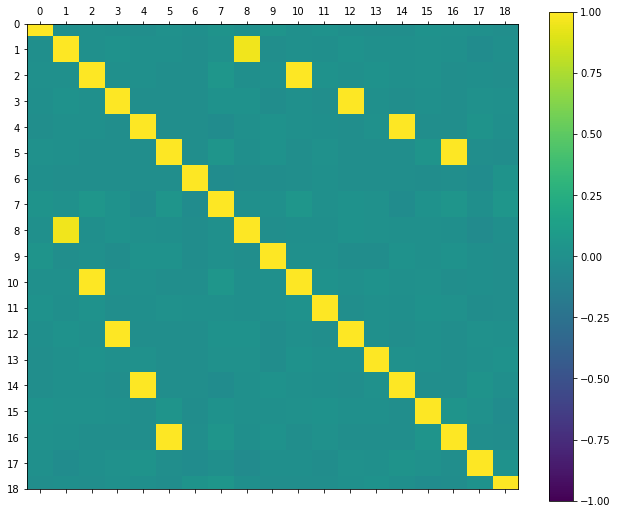


Correlation plot of Numerical features
                Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  \
Account_Length        1.00e+00      -4.63e-03  6.22e-03 -6.76e-03   -8.96e-03   
Vmail_Message        -4.63e-03       1.00e+00  7.78e-04  1.76e-02    7.68e-03   
Day_Mins              6.22e-03       7.78e-04  1.00e+00  7.04e-03    4.32e-03   
Eve_Mins             -6.76e-03       1.76e-02  7.04e-03  1.00e+00   -1.26e-02   
Night_Mins           -8.96e-03       7.68e-03  4.32e-03 -1.26e-02    1.00e+00   
Intl_Mins             9.51e-03       2.86e-03 -1.02e-02 -1.10e-02   -1.52e-02   
CustServ_Calls       -3.80e-03      -1.33e-02 -1.34e-02 -1.30e-02   -9.29e-03   
Intl_Plan             2.47e-02       8.75e-03  4.94e-02  1.91e-02   -2.89e-02   
Vmail_Plan            2.92e-03       9.57e-01 -1.68e-03  2.15e-02    6.08e-03   
Day_Calls             3.85e-02      -9.55e-03  6.75e-03 -2.15e-02    2.29e-02   
Day_Charge            6.21e-03       7.76e-04  1.00e+00  7.05e-03    

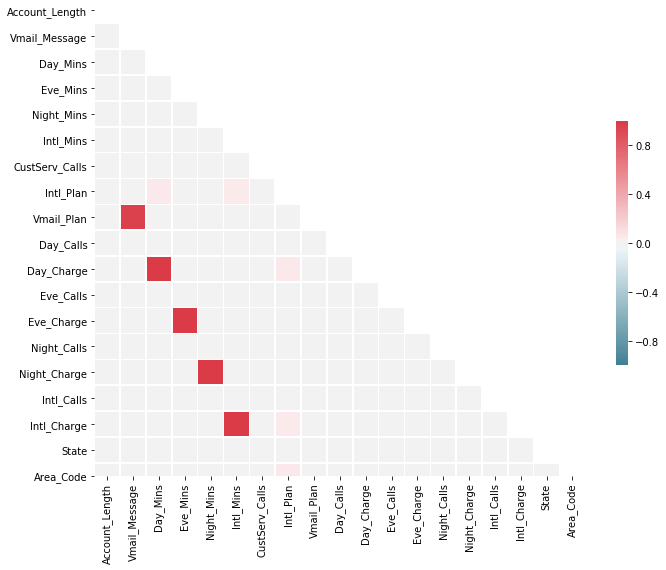


PIE Chart of for Target: 


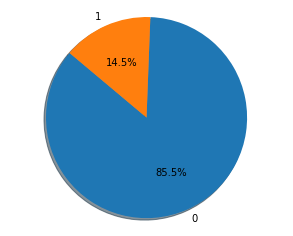

Epoch 1/500
21/21 [==============================] - 0s 2ms/step - loss: 0.4776 - acc: 0.7861
Epoch 2/500
21/21 [==============================] - 0s 3ms/step - loss: 0.3851 - acc: 0.8471
Epoch 3/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3814 - acc: 0.8408
Epoch 4/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3505 - acc: 0.8534
Epoch 5/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3474 - acc: 0.8688
Epoch 6/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3128 - acc: 0.8778
Epoch 7/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3408 - acc: 0.8616
Epoch 8/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3242 - acc: 0.8673
Epoch 9/500
21/21 [==============================] - 0s 2ms/step - loss: 0.2912 - acc: 0.8963
Epoch 10/500
21/21 [==============================] - 0s 2ms/step - loss: 0.2960 - acc: 0.8840
Epoch 11/500
21/21 [==============================] - 0s 2m

21/21 [==============================] - 0s 2ms/step - loss: 0.0303 - acc: 0.9893
Epoch 88/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0702 - acc: 0.9774
Epoch 89/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0438 - acc: 0.9876
Epoch 90/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0332 - acc: 0.9838
Epoch 91/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0494 - acc: 0.9889
Epoch 92/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0364 - acc: 0.9852
Epoch 93/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0178 - acc: 0.9964
Epoch 94/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0356 - acc: 0.9870
Epoch 95/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0142 - acc: 0.9958
Epoch 96/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0580 - acc: 0.9822
Epoch 97/500
21/21 [==============================] - 0s 2ms/st

21/21 [==============================] - 0s 2ms/step - loss: 9.3126e-04 - acc: 1.0000
Epoch 173/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0987 - acc: 0.9863
Epoch 174/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 1.0000
Epoch 175/500
21/21 [==============================] - 0s 2ms/step - loss: 7.0973e-04 - acc: 1.0000
Epoch 176/500
21/21 [==============================] - 0s 2ms/step - loss: 3.5639e-04 - acc: 1.0000
Epoch 177/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0896 - acc: 0.9813
Epoch 178/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0019 - acc: 0.9994
Epoch 179/500
21/21 [==============================] - 0s 2ms/step - loss: 7.2316e-04 - acc: 1.0000
Epoch 180/500
21/21 [==============================] - 0s 2ms/step - loss: 5.0300e-04 - acc: 1.0000
Epoch 181/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0399 - acc: 0.9916
Epoch 182/500
21/21 [=============

21/21 [==============================] - 0s 2ms/step - loss: 1.3594e-04 - acc: 1.0000
Epoch 257/500
21/21 [==============================] - 0s 2ms/step - loss: 0.2143 - acc: 0.9549
Epoch 258/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0152 - acc: 0.9936
Epoch 259/500
21/21 [==============================] - 0s 2ms/step - loss: 2.7193e-04 - acc: 1.0000
Epoch 260/500
21/21 [==============================] - 0s 2ms/step - loss: 3.3598e-04 - acc: 1.0000
Epoch 261/500
21/21 [==============================] - 0s 2ms/step - loss: 5.3191e-05 - acc: 1.0000
Epoch 262/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0148 - acc: 0.9986
Epoch 263/500
21/21 [==============================] - 0s 2ms/step - loss: 0.1743 - acc: 0.9622
Epoch 264/500
21/21 [==============================] - 0s 2ms/step - loss: 2.5041e-04 - acc: 1.0000
Epoch 265/500
21/21 [==============================] - 0s 2ms/step - loss: 1.2117e-04 - acc: 1.0000
Epoch 266/500
21/21 [=========

21/21 [==============================] - 0s 2ms/step - loss: 0.0615 - acc: 0.9918
Epoch 340/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0038 - acc: 0.9989
Epoch 341/500
21/21 [==============================] - 0s 2ms/step - loss: 9.9154e-04 - acc: 1.0000
Epoch 342/500
21/21 [==============================] - 0s 2ms/step - loss: 6.2190e-04 - acc: 1.0000
Epoch 343/500
21/21 [==============================] - 0s 2ms/step - loss: 4.4511e-05 - acc: 1.0000
Epoch 344/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0113 - acc: 0.9986
Epoch 345/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0270 - acc: 0.9911
Epoch 346/500
21/21 [==============================] - 0s 2ms/step - loss: 2.8705e-04 - acc: 1.0000
Epoch 347/500
21/21 [==============================] - 0s 2ms/step - loss: 5.9694e-05 - acc: 1.0000
Epoch 348/500
21/21 [==============================] - 0s 2ms/step - loss: 5.7757e-05 - acc: 1.0000
Epoch 349/500
21/21 [=========

21/21 [==============================] - 0s 2ms/step - loss: 9.5571e-06 - acc: 1.0000
Epoch 423/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3311 - acc: 0.9612
Epoch 424/500
21/21 [==============================] - 0s 2ms/step - loss: 1.0429e-04 - acc: 1.0000
Epoch 425/500
21/21 [==============================] - 0s 2ms/step - loss: 6.0083e-05 - acc: 1.0000
Epoch 426/500
21/21 [==============================] - 0s 2ms/step - loss: 3.8262e-05 - acc: 1.0000
Epoch 427/500
21/21 [==============================] - 0s 2ms/step - loss: 1.6348e-05 - acc: 1.0000
Epoch 428/500
21/21 [==============================] - 0s 2ms/step - loss: 8.7662e-06 - acc: 1.0000
Epoch 429/500
21/21 [==============================] - 0s 2ms/step - loss: 5.8170e-06 - acc: 1.0000
Epoch 430/500
21/21 [==============================] - 0s 2ms/step - loss: 0.1889 - acc: 0.9740
Epoch 431/500
21/21 [==============================] - 0s 2ms/step - loss: 4.2557e-05 - acc: 1.0000
Epoch 432/500
21/21 [=

21/21 [==============================] - 0s 2ms/step - loss: 0.3707 - acc: 0.8422
Epoch 5/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3155 - acc: 0.8656
Epoch 6/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3222 - acc: 0.8613
Epoch 7/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3202 - acc: 0.8604
Epoch 8/500
21/21 [==============================] - 0s 2ms/step - loss: 0.2921 - acc: 0.8824
Epoch 9/500
21/21 [==============================] - 0s 2ms/step - loss: 0.2902 - acc: 0.8835
Epoch 10/500
21/21 [==============================] - 0s 2ms/step - loss: 0.2800 - acc: 0.8910
Epoch 11/500
21/21 [==============================] - 0s 2ms/step - loss: 0.2591 - acc: 0.8960
Epoch 12/500
21/21 [==============================] - 0s 2ms/step - loss: 0.2409 - acc: 0.9172
Epoch 13/500
21/21 [==============================] - 0s 2ms/step - loss: 0.2306 - acc: 0.9077
Epoch 14/500
21/21 [==============================] - 0s 2ms/step - 

21/21 [==============================] - 0s 2ms/step - loss: 0.0151 - acc: 0.9951
Epoch 91/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0204 - acc: 0.9928
Epoch 92/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0762 - acc: 0.9827
Epoch 93/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0186 - acc: 0.9953
Epoch 94/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0200 - acc: 0.9944
Epoch 95/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0158 - acc: 0.9935
Epoch 96/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0722 - acc: 0.9897
Epoch 97/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0262 - acc: 0.9910
Epoch 98/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0199 - acc: 0.9930
Epoch 99/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0430 - acc: 0.9883
Epoch 100/500
21/21 [==============================] - 0s 2ms/s

21/21 [==============================] - 0s 2ms/step - loss: 0.0421 - acc: 0.9943
Epoch 176/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0126 - acc: 0.9955
Epoch 177/500
21/21 [==============================] - 0s 2ms/step - loss: 5.6878e-04 - acc: 1.0000
Epoch 178/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0337 - acc: 0.9942
Epoch 179/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0028 - acc: 0.9995
Epoch 180/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 1.0000
Epoch 181/500
21/21 [==============================] - 0s 2ms/step - loss: 1.8179e-04 - acc: 1.0000
Epoch 182/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0166 - acc: 0.9971
Epoch 183/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0246 - acc: 0.9907
Epoch 184/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0023 - acc: 0.9984
Epoch 185/500
21/21 [=========================

21/21 [==============================] - 0s 2ms/step - loss: 0.1296 - acc: 0.9709
Epoch 259/500
21/21 [==============================] - 0s 3ms/step - loss: 3.1534e-04 - acc: 1.0000
Epoch 260/500
21/21 [==============================] - 0s 2ms/step - loss: 3.1198e-04 - acc: 1.0000
Epoch 261/500
21/21 [==============================] - 0s 2ms/step - loss: 8.1219e-05 - acc: 1.0000
Epoch 262/500
21/21 [==============================] - 0s 2ms/step - loss: 3.1641e-05 - acc: 1.0000
Epoch 263/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0883 - acc: 0.9771
Epoch 264/500
21/21 [==============================] - 0s 2ms/step - loss: 4.5826e-04 - acc: 1.0000
Epoch 265/500
21/21 [==============================] - 0s 2ms/step - loss: 2.0968e-04 - acc: 1.0000
Epoch 266/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0374 - acc: 0.9959
Epoch 267/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0159 - acc: 0.9936
Epoch 268/500
21/21 [=========

21/21 [==============================] - 0s 2ms/step - loss: 3.2686e-05 - acc: 1.0000
Epoch 342/500
21/21 [==============================] - 0s 2ms/step - loss: 1.4475e-05 - acc: 1.0000
Epoch 343/500
21/21 [==============================] - 0s 2ms/step - loss: 7.4261e-06 - acc: 1.0000
Epoch 344/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0073 - acc: 0.9990
Epoch 345/500
21/21 [==============================] - 0s 2ms/step - loss: 0.1196 - acc: 0.9728
Epoch 346/500
21/21 [==============================] - 0s 2ms/step - loss: 8.6835e-04 - acc: 1.0000
Epoch 347/500
21/21 [==============================] - 0s 2ms/step - loss: 9.6441e-05 - acc: 1.0000
Epoch 348/500
21/21 [==============================] - 0s 2ms/step - loss: 4.8567e-05 - acc: 1.0000
Epoch 349/500
21/21 [==============================] - 0s 2ms/step - loss: 2.1260e-05 - acc: 1.0000
Epoch 350/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3829 - acc: 0.9654
Epoch 351/500
21/21 [=====

21/21 [==============================] - 0s 2ms/step - loss: 1.8809e-06 - acc: 1.0000
Epoch 424/500
21/21 [==============================] - 0s 2ms/step - loss: 9.1332e-07 - acc: 1.0000
Epoch 425/500
21/21 [==============================] - 0s 2ms/step - loss: 5.4804e-07 - acc: 1.0000
Epoch 426/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3478 - acc: 0.9619
Epoch 427/500
21/21 [==============================] - 0s 2ms/step - loss: 2.0343e-04 - acc: 1.0000
Epoch 428/500
21/21 [==============================] - 0s 2ms/step - loss: 7.6823e-04 - acc: 1.0000
Epoch 429/500
21/21 [==============================] - 0s 2ms/step - loss: 6.0032e-05 - acc: 1.0000
Epoch 430/500
21/21 [==============================] - 0s 2ms/step - loss: 4.5132e-06 - acc: 1.0000
Epoch 431/500
21/21 [==============================] - 0s 2ms/step - loss: 1.8044e-06 - acc: 1.0000
Epoch 432/500
21/21 [==============================] - 0s 2ms/step - loss: 1.5891e-06 - acc: 1.0000
Epoch 433/500
21/2

34/34 [==============================] - 0s 3ms/step - loss: 0.3520 - acc: 0.8586 - val_loss: 0.4475 - val_acc: 0.8408
Epoch 4/500
34/34 [==============================] - 0s 3ms/step - loss: 0.3348 - acc: 0.8607 - val_loss: 0.3541 - val_acc: 0.8596
Epoch 5/500
34/34 [==============================] - 0s 3ms/step - loss: 0.3293 - acc: 0.8659 - val_loss: 0.3490 - val_acc: 0.8427
Epoch 6/500
34/34 [==============================] - 0s 3ms/step - loss: 0.3017 - acc: 0.8698 - val_loss: 0.3414 - val_acc: 0.8633
Epoch 7/500
34/34 [==============================] - 0s 3ms/step - loss: 0.3008 - acc: 0.8891 - val_loss: 0.3808 - val_acc: 0.8539
Epoch 8/500
34/34 [==============================] - 0s 3ms/step - loss: 0.2524 - acc: 0.8957 - val_loss: 0.3751 - val_acc: 0.8371
Epoch 9/500
34/34 [==============================] - 0s 3ms/step - loss: 0.2563 - acc: 0.8970 - val_loss: 0.3284 - val_acc: 0.8745
Epoch 10/500
34/34 [==============================] - 0s 3ms/step - loss: 0.2440 - acc: 0.9131 

34/34 [==============================] - 0s 3ms/step - loss: 0.1140 - acc: 0.9575 - val_loss: 0.9757 - val_acc: 0.8839
Epoch 66/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0905 - acc: 0.9652 - val_loss: 0.8096 - val_acc: 0.8727
Epoch 67/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0765 - acc: 0.9658 - val_loss: 0.7424 - val_acc: 0.8989
Epoch 68/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0662 - acc: 0.9738 - val_loss: 0.7329 - val_acc: 0.8801
Epoch 69/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0628 - acc: 0.9758 - val_loss: 0.6949 - val_acc: 0.8633
Epoch 70/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0812 - acc: 0.9671 - val_loss: 0.7152 - val_acc: 0.8652
Epoch 71/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0615 - acc: 0.9757 - val_loss: 0.9158 - val_acc: 0.8652
Epoch 72/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0676 - acc: 0

Epoch 127/500
34/34 [==============================] - 0s 2ms/step - loss: 0.0206 - acc: 0.9945 - val_loss: 1.6522 - val_acc: 0.8876
Epoch 128/500
34/34 [==============================] - 0s 2ms/step - loss: 0.0582 - acc: 0.9777 - val_loss: 1.3251 - val_acc: 0.8933
Epoch 129/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0216 - acc: 0.9917 - val_loss: 1.4867 - val_acc: 0.8221
Epoch 130/500
34/34 [==============================] - 0s 3ms/step - loss: 0.1611 - acc: 0.9722 - val_loss: 1.2579 - val_acc: 0.8614
Epoch 131/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0233 - acc: 0.9931 - val_loss: 1.1509 - val_acc: 0.8876
Epoch 132/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0376 - acc: 0.9843 - val_loss: 1.2828 - val_acc: 0.8858
Epoch 133/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0328 - acc: 0.9919 - val_loss: 1.4627 - val_acc: 0.8801
Epoch 134/500
34/34 [==============================] - 0s 3ms/step - 

34/34 [==============================] - 0s 3ms/step - loss: 0.0157 - acc: 0.9952 - val_loss: 1.6385 - val_acc: 0.8876
Epoch 189/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0355 - acc: 0.9916 - val_loss: 1.5271 - val_acc: 0.8933
Epoch 190/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 1.8086 - val_acc: 0.8876
Epoch 191/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0235 - acc: 0.9948 - val_loss: 1.7303 - val_acc: 0.8783
Epoch 192/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0036 - acc: 0.9981 - val_loss: 1.8330 - val_acc: 0.8801
Epoch 193/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0263 - acc: 0.9937 - val_loss: 1.8507 - val_acc: 0.8689
Epoch 194/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0211 - acc: 0.9932 - val_loss: 1.9176 - val_acc: 0.8708
Epoch 195/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0322 -

34/34 [==============================] - 0s 3ms/step - loss: 0.0711 - acc: 0.9770 - val_loss: 1.9509 - val_acc: 0.8727
Epoch 250/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0390 - acc: 0.9909 - val_loss: 1.6284 - val_acc: 0.9007
Epoch 251/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0039 - acc: 0.9991 - val_loss: 1.9286 - val_acc: 0.8745
Epoch 252/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0419 - acc: 0.9918 - val_loss: 1.8305 - val_acc: 0.8783
Epoch 253/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 1.9937 - val_acc: 0.8820
Epoch 254/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0184 - acc: 0.9973 - val_loss: 1.9730 - val_acc: 0.8727
Epoch 255/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0080 - acc: 0.9984 - val_loss: 2.2399 - val_acc: 0.8876
Epoch 256/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0161 -

34/34 [==============================] - 0s 3ms/step - loss: 0.0191 - acc: 0.9909 - val_loss: 1.8662 - val_acc: 0.8820
Epoch 311/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0128 - acc: 0.9955 - val_loss: 1.8659 - val_acc: 0.8764
Epoch 312/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0097 - acc: 0.9965 - val_loss: 1.6938 - val_acc: 0.8820
Epoch 313/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0163 - acc: 0.9953 - val_loss: 1.5769 - val_acc: 0.8783
Epoch 314/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0068 - acc: 0.9970 - val_loss: 1.8482 - val_acc: 0.8745
Epoch 315/500
34/34 [==============================] - 0s 3ms/step - loss: 3.3947e-04 - acc: 1.0000 - val_loss: 2.0777 - val_acc: 0.8801
Epoch 316/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0187 - acc: 0.9942 - val_loss: 1.9487 - val_acc: 0.8801
Epoch 317/500
34/34 [==============================] - 0s 3ms/step - loss: 0.00

34/34 [==============================] - 0s 3ms/step - loss: 0.0139 - acc: 0.9976 - val_loss: 2.1167 - val_acc: 0.8689
Epoch 372/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0279 - acc: 0.9926 - val_loss: 1.9899 - val_acc: 0.8876
Epoch 373/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0027 - acc: 0.9993 - val_loss: 1.9618 - val_acc: 0.8689
Epoch 374/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0342 - acc: 0.9915 - val_loss: 1.9366 - val_acc: 0.8839
Epoch 375/500
34/34 [==============================] - 0s 3ms/step - loss: 5.3854e-04 - acc: 1.0000 - val_loss: 2.0677 - val_acc: 0.8783
Epoch 376/500
34/34 [==============================] - 0s 3ms/step - loss: 5.5853e-04 - acc: 0.9999 - val_loss: 1.9112 - val_acc: 0.8801
Epoch 377/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0717 - acc: 0.9799 - val_loss: 2.0023 - val_acc: 0.8876
Epoch 378/500
34/34 [==============================] - 0s 3ms/step - loss: 

34/34 [==============================] - 0s 3ms/step - loss: 0.0399 - acc: 0.9926 - val_loss: 1.8430 - val_acc: 0.8839
Epoch 433/500
34/34 [==============================] - 0s 3ms/step - loss: 9.9137e-04 - acc: 0.9999 - val_loss: 2.1686 - val_acc: 0.8652
Epoch 434/500
34/34 [==============================] - 0s 3ms/step - loss: 0.1760 - acc: 0.9762 - val_loss: 1.9153 - val_acc: 0.8839
Epoch 435/500
34/34 [==============================] - 0s 3ms/step - loss: 5.4634e-04 - acc: 1.0000 - val_loss: 2.1747 - val_acc: 0.8858
Epoch 436/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0114 - acc: 0.9978 - val_loss: 1.9276 - val_acc: 0.8951
Epoch 437/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0046 - acc: 0.9982 - val_loss: 2.0528 - val_acc: 0.8839
Epoch 438/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0041 - acc: 0.9995 - val_loss: 2.5355 - val_acc: 0.8708
Epoch 439/500
34/34 [==============================] - 0s 3ms/step - loss: 

34/34 [==============================] - 0s 3ms/step - loss: 0.0171 - acc: 0.9938 - val_loss: 1.7753 - val_acc: 0.8858
Epoch 494/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0315 - acc: 0.9915 - val_loss: 1.7550 - val_acc: 0.8820
Epoch 495/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0042 - acc: 0.9983 - val_loss: 1.9904 - val_acc: 0.8839
Epoch 496/500
34/34 [==============================] - 0s 2ms/step - loss: 0.0108 - acc: 0.9986 - val_loss: 1.8694 - val_acc: 0.8633
Epoch 497/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0211 - acc: 0.9967 - val_loss: 2.0609 - val_acc: 0.8727
Epoch 498/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0029 - acc: 0.9981 - val_loss: 2.0862 - val_acc: 0.8745
Epoch 499/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0404 - acc: 0.9954 - val_loss: 1.6426 - val_acc: 0.8876
Epoch 500/500
34/34 [==============================] - 0s 3ms/step - loss: 0.0420 -

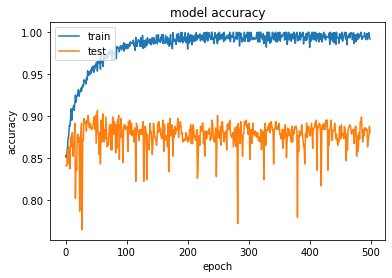

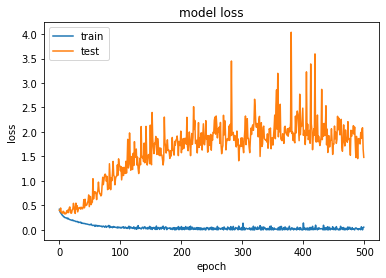

11/11 [==============================] - 0s 818us/step

Evaluation of the trained model: 

Accuracy :  0.9175412293853074

Kappa Score :  0.6235312227410335

Confusion Matrix :
 [[556  27]
 [ 28  56]]

Classification Report :
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       583
           1       0.67      0.67      0.67        84

    accuracy                           0.92       667
   macro avg       0.81      0.81      0.81       667
weighted avg       0.92      0.92      0.92       667

11/11 [==============================] - 0s 859us/step


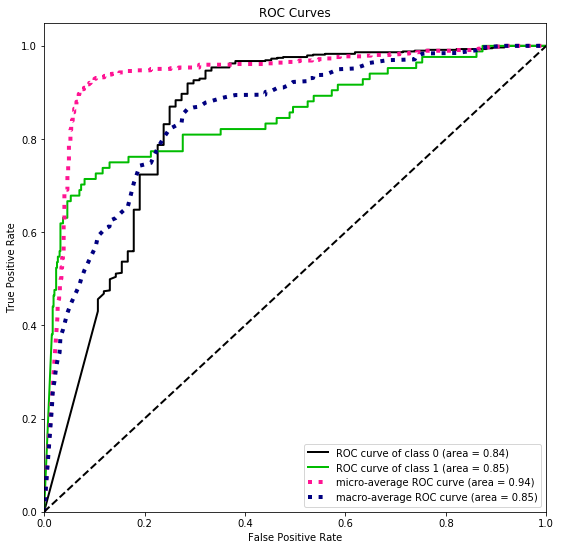

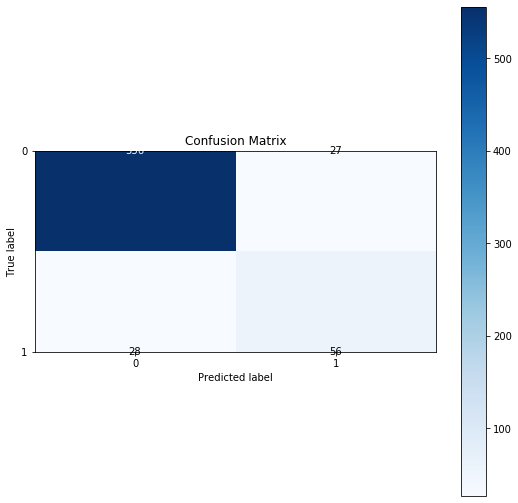

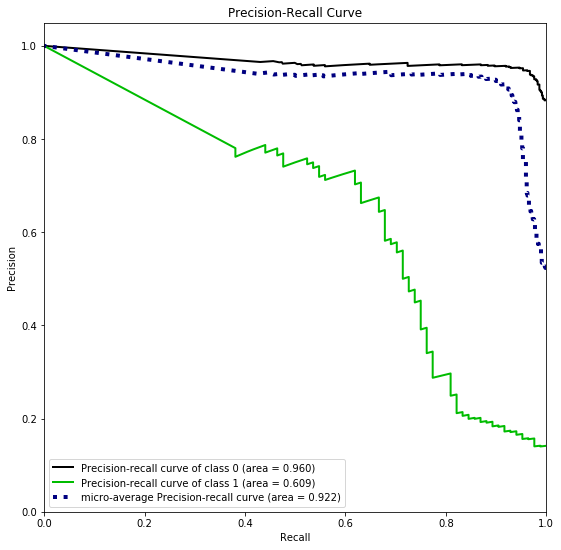

(3333, 21)
   Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  Intl_Mins  \
0             128             25     265.1     197.4       244.7       10.0   
1             107             26     161.6     195.5       254.4       13.7   
2             137              0     243.4     121.2       162.6       12.2   
3              84              0     299.4      61.9       196.9        6.6   
4              75              0     166.7     148.3       186.9       10.1   

   CustServ_Calls Churn Intl_Plan Vmail_Plan  ...  Day_Charge  Eve_Calls  \
0               1    no        no        yes  ...       45.07         99   
1               1    no        no        yes  ...       27.47        103   
2               0    no        no         no  ...       41.38        110   
3               2    no       yes         no  ...       50.90         88   
4               3    no       yes         no  ...       28.34        122   

   Eve_Charge  Night_Calls  Night_Charge  Intl_Calls  Int

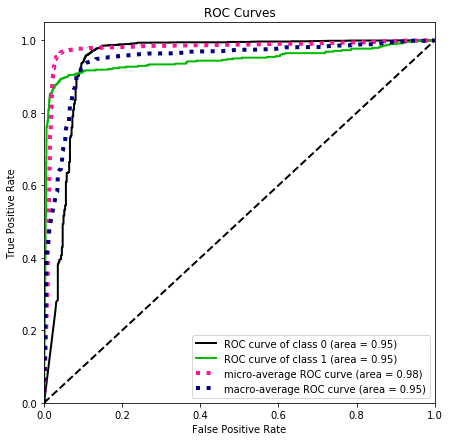

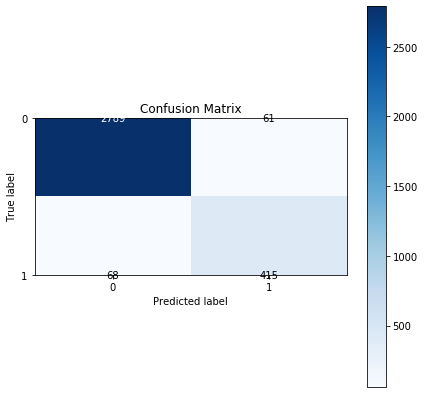

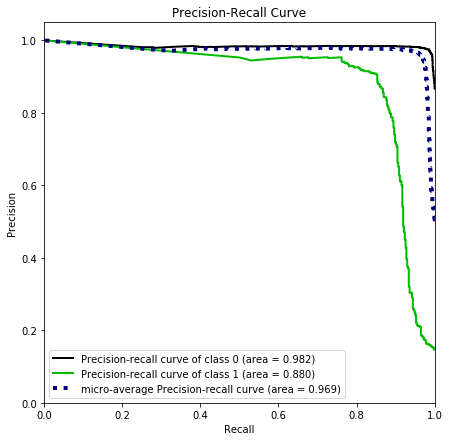


Execution Time 539.4980857372284 seconds: 


In [19]:
    if __name__ == '__main__':
        print()
        print("Execution Time %s seconds: " % (start_time))
        filename = 'TelcoCustomerChurnDataset.csv'
        
        feature_names, target, dataset = load_dataset(filename)
        dataset = find_miising_value(feature_names, target, dataset)
        data_descriptiveStats(feature_names, target, dataset)
        data_visualization(feature_names, target, dataset)
        X_train, X_test, y_train, y_test = data_split(feature_names, target, dataset)
        model, history  = training_model(X_train, y_train)
        model= evaluate_model(model, history, X_test, y_test)

        save_model(model) 
        final_prediction(feature_names, filename)
        
        print()
        print("Execution Time %s seconds: " % (time.time() - start_time))

## References 

<ol>
    <li><a href="https://www.tensorflow.org/">Tensorflow</a></li>
</ol>